In [6]:
%matplotlib notebook

from __future__ import print_function, absolute_import, division
import numpy as np
import tables
from heartnet_v1 import reshape_folds
from keras.utils import to_categorical
from keras import backend as K
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from keras.models import model_from_json
from custom_layers import Conv1D_linearphaseType, Conv1D_linearphase, DCT1D, \
            Conv1D_gammatone, Conv1D_linearphaseType_legacy, Conv1D_zerophase
from sklearn.metrics import f1_score,confusion_matrix
from scipy import signal
sns.set()

## Utils

In [98]:
def get_activations(model, model_inputs, batch_size=64,print_shape_only=True, layer_name=None):
    '''
    Get activations from a specific layer of a trained model
    '''
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    
    start_idx = 0
    for idx in range(batch_size,len(model_inputs),batch_size):
        
        if model_multi_inputs_cond:
            raise NotImplementedError
        else:
            list_inputs = [model_inputs[start_idx:idx], 0.]

        # Learning phase. 0 = Test mode (no dropout or batch normalization)
        # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
        layer_outputs = [func(list_inputs)[0] for func in funcs]
        for layer_activations in layer_outputs:
            activations.append(layer_activations)
#             if print_shape_only:
#                 print(layer_activations.shape)
#             else:
#                 print(layer_activations)
        start_idx = idx
    return np.vstack(activations)


def display_activations(activation_maps):
    '''
    Plot activations
    '''
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
            if num_activations > 1024:  # too hard to display it on the screen.
                square_param = int(np.floor(np.sqrt(num_activations)))
                activations = activations[0: square_param * square_param]
                activations = np.reshape(activations, (square_param, square_param))
            else:
                activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        plt.imshow(activations, interpolation='None', cmap='jet')
    plt.show()

def get_weights(log_name,min_metric=.7,min_epoch=50,verbose=1):
    '''
    Load weights from training.csv file
    '''
    log_dir = '/media/taufiq/Data1/heart_sound/logs'
    
    if not os.path.isdir(os.path.join(log_dir,log_name)):
        log_dir = '/media/taufiq/Data1/heart_sound/logArxiv'
    training_csv = os.path.join(log_dir,log_name,"training.csv")
    df = pd.read_csv(training_csv)
    sens_idx = df['val_sensitivity'][df.epoch>min_epoch][df.val_specificity>min_metric].idxmax()
    spec_idx = df['val_specificity'][df.epoch>min_epoch][df.val_sensitivity>min_metric].idxmax()
    macc_idx = df['val_macc'][df.epoch>min_epoch].idxmax()
    val_idx = df['val_acc'][df.epoch>min_epoch].idxmax()
    weights = dict()
    weights['val_sensitivity'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[sens_idx]+1,df.val_acc.iloc[sens_idx])
    weights['val_specificity'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[spec_idx]+1,df.val_acc.iloc[spec_idx])
    weights['val_macc'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[macc_idx]+1,df.val_acc.iloc[macc_idx])
    weights['val_acc'] = "weights.%.4d-%.4f.hdf5" % (df.epoch.iloc[val_idx]+1,df.val_acc.iloc[val_idx])
    if verbose:
        print("Best Sensitivity model: {} \t\t{}".format(df.val_sensitivity.iloc[sens_idx],weights['val_sensitivity']))
        print("Best Specificity model: {} \t\t{}".format(df.val_specificity.iloc[spec_idx],weights['val_specificity']))
        print("Best Macc model: {} \t\t{}".format(df.val_macc.iloc[macc_idx],weights['val_macc']))
        print("Best Val model: {} \t\t\t{}".format(df.val_acc.iloc[val_idx],weights['val_acc']))
    return weights

def load_data(foldname,fold_dir=None,_categorical=True,quality=False):
    ## import data
    if fold_dir is None:
        fold_dir = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/folds_dec_2018/'
    
    feat = tables.open_file(fold_dir + foldname + '.mat')
    x_train = feat.root.trainX[:]
    y_train = feat.root.trainY[0, :]
    q_train = feat.root.trainY[1, :]
    x_val = feat.root.valX[:]
    y_val = feat.root.valY[0, :]
    q_val = feat.root.valY[1, :]
    train_parts = feat.root.train_parts[:]
    val_parts = feat.root.val_parts[0, :]

    ############## Relabeling ################
    
    for i in range(0, y_train.shape[0]):
        if y_train[i] == -1:
            y_train[i] = 0  ## Label 0 for normal 1 for abnormal
    for i in range(0, y_val.shape[0]):
        if y_val[i] == -1:
            y_val[i] = 0

    ############# Parse Database names ########

    train_files = []
    for each in feat.root.train_files[:][0]:
        train_files.append(chr(each))
    print(len(train_files))
    val_files = []
    for each in feat.root.val_files[:][0]:
        val_files.append(chr(each))
    print(len(val_files))

    ################### Reshaping ############

    x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)

    if _categorical:
        y_train = to_categorical(y_train, num_classes=2)
        y_val = to_categorical(y_val, num_classes=2)
    
    if quality:
        return x_train, y_train, train_files, train_parts, q_train, \
                x_val, y_val, val_files, val_parts, q_val
    else:
        return x_train, y_train, train_files, train_parts, \
                x_val, y_val, val_files, val_parts

def load_model(log_name,verbose=0):
    
    model_dir = '/media/taufiq/Data1/heart_sound/models/'
    log_dir = '/media/taufiq/Data1/heart_sound/logs/'

    if os.path.isdir(model_dir+log_name):
        print("Model directory found")
        if os.path.isfile(os.path.join(model_dir+log_name,"model.json")):
            print("model.json found. Importing")
        else:
            raise ImportError("model.json not found")

    with open(os.path.join(model_dir+log_name,"model.json")) as json_file:
        loaded_model_json = json_file.read()
    try:
        model = model_from_json(loaded_model_json,{'Conv1D_linearphase':Conv1D_linearphase,
                                               'DCT1D':DCT1D,
                                               'Conv1D_linearphaseType':Conv1D_linearphaseType,
                                               'Conv1D_gammatone' : Conv1D_gammatone,
                                                'Conv1D_zerophase' : Conv1D_zerophase,
                                              })
    except:
        model = model_from_json(loaded_model_json,{'Conv1D_linearphase':Conv1D_linearphase,
                                               'DCT1D':DCT1D,
                                               'Conv1D_linearphaseType':Conv1D_linearphaseType_legacy,
                                               'Conv1D_gammatone' : Conv1D_gammatone,
                                                   'Conv1D_zerophase' : Conv1D_zerophase,
                                              })
        
    if verbose:
        print(log_name)
        model.summary()
    return model

def cc2parts(cc,parts):
    
    if not len(cc) == sum(parts):
        raise ValueError('Number of CC elements are not equal to total number of parts')
    
    labels = []
    start_idx = 0
    cc = np.round(cc)
    
    for s in parts:
        if not s:  ## for e00032 in validation0 there was no cardiac cycle
            continue
        temp = cc[start_idx:start_idx + int(s)]
        labels.append(sum(temp)/len(temp))
        start_idx = start_idx + int(s)
    return np.asarray(labels)

def parts2cc(partitioned,parts):
    
    labels = []
    parts = parts[np.nonzero(parts)]
    for each,part in zip(partitioned,parts):
            labels += list(np.repeat(each,part))
    return np.asarray(labels)

def predict_parts(model,data,labels,parts,filenames=None,verbose=1):
    y_pred = model.predict(data, verbose=verbose)
    true = []
    pred = []
    files= []
    start_idx = 0
    y_pred = np.argmax(y_pred, axis=-1)
    y_val = np.transpose(np.argmax(labels, axis=-1))
    for s in parts:
        if not s:  ## for e00032 in validation0 there was no cardiac cycle
            continue
        # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)
        temp_ = y_val[start_idx:start_idx + int(s)]
        temp = y_pred[start_idx:start_idx + int(s)]
        if (sum(temp == 0) > sum(temp == 1)):
            pred.append(0)
        else:
            pred.append(1)

        if (sum(temp_ == 0) > sum(temp_ == 1)):
            true.append(0)
        else:
            true.append(1)

        if filenames is not None:
            files.append(filenames[start_idx])
        start_idx = start_idx + int(s)
    return pred,true,files

def calc_metrics(true,pred,files=None,verbose=1,eps=1E-10):
            TN, FP, FN, TP = confusion_matrix(true, pred, labels=[0,1]).ravel()
            sensitivity = TP / (TP + FN + eps)
            specificity = TN / (TN + FP + eps)
            precision = TP / (TP + FP + eps)
            F1 = 2 * (precision * sensitivity) / (precision + sensitivity + eps)
            Macc = (sensitivity + specificity) / 2
            logs = dict()
            logs['val_sensitivity'] = np.array(sensitivity)
            logs['val_specificity'] = np.array(specificity)
            logs['val_precision'] = np.array(precision)
            logs['val_F1'] = np.array(F1)
            logs['val_macc'] = np.array(Macc)
            if verbose:
                print("TN:{},FP:{},FN:{},TP:{},Macc:{},F1:{}".format(TN, FP, FN, TP,Macc,F1))
            if files is not None:
                true = np.asarray(true)
                pred = np.asarray(pred)
                files = np.asarray(files)
                tpn = true == pred
                for dataset in set(files):
                    mask = files == dataset
                    logs['acc_'+dataset] = np.sum(tpn[mask])/np.sum(mask)
            return logs


def log_fusion(logs,data,labels,fusion_weights=None,min_epoch=20,min_metric=.7,
               metric='val_macc',model_dir='/media/taufiq/Data1/heart_sound/models/',verbose=0):        
    '''
    Returns fused predictions
    '''
    if not type(logs) == list:
        logs = [logs]
    
    if fusion_weights is None:
        fusion_weights = np.ones((len(logs)))
    else:
        if not len(logs)==len(fusion_weights):
            raise ValueError('Fusion weights not consistent with number of models')
    pred = np.zeros((data.shape[0],2))
    
    for log_name,weight in zip(logs,fusion_weights):
        model = load_model(log_name,verbose=verbose)
        weights = get_weights(log_name,min_epoch=min_epoch,
                              min_metric=min_metric,verbose=verbose)
        checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
        model.load_weights(checkpoint_name)
        pred += model.predict(data,verbose=verbose)*weight
    pred /= sum(fusion_weights)
    # pred = np.argmax(pred,axis=-1)
    return pred

def model_confidence(model,data,labels,verbose=0):
    '''
    Give confidence score for true class
    '''
    pred = model.predict(data,verbose=verbose)
    
    if np.asarray(labels).ndim >1:
        labels = np.argmax(labels,axis=-1)
    
    pred = [pred[idx,each] for idx,each in enumerate(labels)]
    
    return np.asarray(pred)

def plot_coeff(logs,branches=[1,2,3,4],min_epoch=20,min_metric=.7,
             metric='val_macc',model_dir='/media/taufiq/Data1/heart_sound/models/',
             figsize=(10,6),verbose=0):
    '''
    Plot Learnable FIRs for logs
    '''
    if not type(logs) == list:
        logs = [logs]
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(len(branches), len(logs), sharex='col', sharey='row', figsize=figsize)
    
    for _idx,log_name in enumerate(logs):
        model = load_model(log_name,verbose=verbose)
        weights = get_weights(log_name,min_epoch=min_epoch,
                              min_metric=min_metric,verbose=verbose)
        checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
        model.load_weights(checkpoint_name)
        
        FIR_coeff = []
        layer_name = []
        layer_type = []
        
        ## Get filter coefficients
        for branch in branches:
            if not 'gammatone' in model.layers[branch].name:
                FIR_coeff.append(np.asarray(model.layers[branch].get_weights())[0,:,0,0])
                layer_name.append(model.layers[branch].name)
            else: # for gammatone
                FIR_coeff.append(K.get_session().run(model.layers[branch].impulse_gammatone()))
                layer_name.append(model.layers[branch].name)
            try:
                layer_type.append(model.layers[branch].type)
            except: # if not linear phase
                layer_type.append(0)
        
        for idx,coeff in enumerate(FIR_coeff):
            
            ## Flip-concat coefficients for Linearphase
            if 'linearphase' in layer_name[idx]:
                if layer_type[idx] % 2:
                    FIR_coeff[idx] = np.concatenate([np.flip(FIR_coeff[idx][1:],axis=0),FIR_coeff[idx]])
                else:
                    FIR_coeff[idx] = np.concatenate([np.flip(FIR_coeff[idx],axis=0),FIR_coeff[idx]])
            
            ax[idx,_idx].plot((FIR_coeff[idx]-np.mean(FIR_coeff[idx]))/np.std(FIR_coeff[idx]))
    
    plt.tight_layout()     
    plt.show()
    return ax
    
def plot_freq(logs,branches=[1,2,3,4],phase=False,min_epoch=20,min_metric=.7,
             metric='val_macc',model_dir='/media/taufiq/Data1/heart_sound/models/',
             figsize=(10,6),verbose=0):
    '''
    Plot Learnable FIRs for logs
    '''
    if not type(logs) == list:
        logs = [logs]
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(len(branches), len(logs), sharex='col', sharey='row', figsize=figsize)
    
    for _idx,log_name in enumerate(logs):
        model = load_model(log_name,verbose=verbose)
        weights = get_weights(log_name,min_epoch=min_epoch,
                              min_metric=min_metric,verbose=verbose)
        checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
        model.load_weights(checkpoint_name)
        
        FIR_coeff = []
        layer_name = []
        layer_type = []
        
        ## Get filter coefficients
        for branch in branches:
            if not 'gammatone' in model.layers[branch].name:
                FIR_coeff.append(np.asarray(model.layers[branch].get_weights())[0,:,0,0])
                layer_name.append(model.layers[branch].name)
            else: # for gammatone
                FIR_coeff.append(K.get_session().run(model.layers[branch].impulse_gammatone()))
                layer_name.append(model.layers[branch].name)
            try:
                layer_type.append(model.layers[branch].type)
            except: # if not linear phase
                layer_type.append(0)
        
        for idx,coeff in enumerate(FIR_coeff):
            
            ## Flip-concat coefficients for Linearphase
            if 'linearphase' in layer_name[idx]:
                if layer_type[idx] % 2:
                    FIR_coeff[idx] = np.concatenate([np.flip(FIR_coeff[idx][1:],axis=0),FIR_coeff[idx]])
                else:
                    FIR_coeff[idx] = np.concatenate([np.flip(FIR_coeff[idx],axis=0),FIR_coeff[idx]])
            
            w,freq_res=signal.freqz(FIR_coeff[idx])
            ax[idx,_idx].plot(w/np.pi*500,10*np.log10(abs(freq_res)/max(abs(freq_res))))
            if phase:
                angles = np.unwrap(np.angle(freq_res))
                ax2 = ax[idx,_idx].twinx()
                ax2.plot(w/np.pi*500, angles, 'g')

    plt.tight_layout()     
#     plt.show()
    return ax

<IPython.core.display.Javascript object>


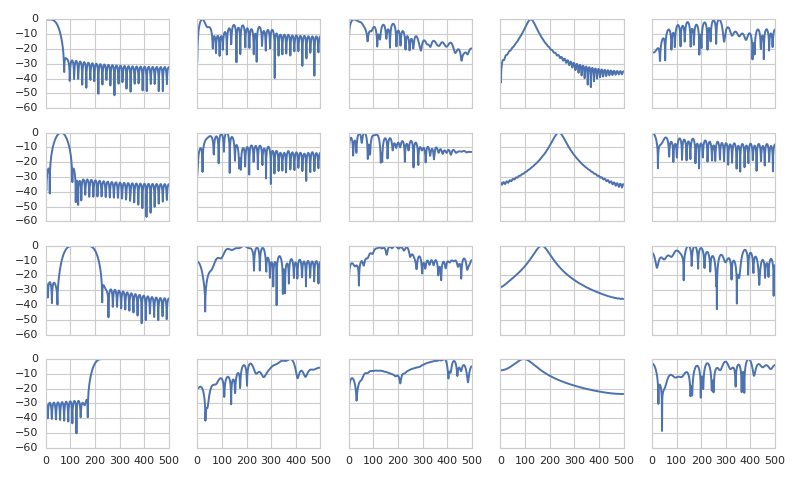

Model directory found
model.json found. Importing
Model directory found
model.json found. Importing
Model directory found
model.json found. Importing
Model directory found
model.json found. Importing
Model directory found
model.json found. Importing


In [97]:
plot_freq([
          "potes_fold0_noFIR 2019-03-02 13:01:33.636778",
          "fold0_noFIR 2019-02-24 18:02:57.053839",
#           "fold0_noFIR 2019-02-27 19:52:21.543329",
#           "fold2_noFIR 2019-01-17 04:16:51.868927", # random
#           "fold1_noFIR 2019-01-13 15:04:39.094472", 
#           "fold1_noFIR 2019-02-16 12:28:19.127331", # densenet
#             "fold0_noFIR 2019-03-06 14:21:29.823568", # bi-conv stage1
            "fold0_noFIR 2019-03-06 21:42:10.719836", # bi-conv stage2
            "fold0_noFIR 2019-03-09 01:34:03.547265", #gamma stage 1
#             "fold0_noFIR 2019-03-09 07:12:26.773316", #gamma stage 2
            "fold0_noFIR 2019-03-08 03:28:46.740442", #type3
         ],min_epoch=80)
plt.show()

## Load model and Data

In [111]:
foldname = 'fold1+compare'
fold_dir = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/'

x_train, y_train, train_files,train_parts, q_train, \
    x_val, y_val,val_files,val_parts, q_val = load_data(foldname,fold_dir,quality=True)
    
test_parts = train_parts[0][np.asarray(train_files) =='x']
test_parts = np.concatenate([test_parts,val_parts[np.asarray(val_files)=='x']],axis=0)
train_files = parts2cc(train_files,train_parts[0])
val_files = parts2cc(val_files,val_parts)
x_test = x_train[train_files == 'x']
x_test = np.concatenate([x_test,x_val[val_files=='x']])
y_test = y_train[train_files == 'x']
y_test = np.concatenate([y_test,y_val[val_files=='x']])
test_files = np.concatenate([train_files[train_files == 'x'],
                            val_files[val_files == 'x']])
q_test = np.concatenate([q_train[train_files == 'x'],
                            q_val[val_files == 'x']])
del x_train, y_train, train_files,train_parts, q_train, \
    x_val, y_val,val_files,val_parts, q_val

foldname = 'fold0_noFIR'
# log_name = "fold0_noFIR 2019-02-27 19:52:21.543329"
# log_name = "fold0_noFIR 2019-02-24 18:02:57.053839" # Type1 macc
# log_name = "potes_fold0_noFIR 2019-03-02 13:01:33.636778" # potes
# log_name = "fold0_noFIR 2019-03-09 01:34:03.547265" #gamma stage 1
# log_name = "fold0_noFIR 2019-03-07 14:44:47.022240" # Type2 macc 80 epoch
log_name = "fold0_noFIR 2019-03-08 03:28:46.740442" # Type3


x_train, y_train, train_files,train_parts, q_train, \
    x_val, y_val,val_files,val_parts, q_val = load_data(foldname,quality=True) # also return recording quality

train_parts = train_parts[np.nonzero(train_parts)] ## Some have zero cardiac cycle
val_parts = val_parts[np.nonzero(val_parts)]

model = load_model(log_name,verbose=1)
weights = get_weights(log_name,min_epoch=100,min_metric=.6)

3283
515
(93942, 2500, 1)
(93942, 1)
(15511, 2500, 1)
(15511, 1)
79810
6710
(79810, 2500, 1)
(79810, 1)
(6710, 2500, 1)
(6710, 1)
Model directory found
model.json found. Importing
fold0_noFIR 2019-03-08 03:28:46.740442
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2500, 1)      0                                            
__________________________________________________________________________________________________
conv1d_linearphase_type_1 (Conv (None, 2500, 1)      31          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_linearphase_type_2 (Conv (None, 2500, 1)      31          input_1[0][0]                    
________________________________________________________________________________________

In [112]:
np.bincount(np.argmax(y_test,axis=-1))/sum(np.bincount(np.argmax(y_test,axis=-1)))

array([0.17529325, 0.82470675])

## Load model weights

In [113]:
metric = 'val_macc'
model_dir = '/media/taufiq/Data1/heart_sound/models/'

checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
model.load_weights(checkpoint_name)
print("Checkpoint loaded:\n %s" % checkpoint_name)

Checkpoint loaded:
 /media/taufiq/Data1/heart_sound/models/fold0_noFIR 2019-03-08 03:28:46.740442/weights.0142-0.7544.hdf5


## Model.predict

In [114]:
##### print('Calculating metrics for all of Validation')
pred,true,files = predict_parts(model,x_val,y_val,val_parts,val_files)
res = calc_metrics(true,pred,files)
print(res.items())

print('\n\nCalculating metrics for good quality only')
pred,true,files = predict_parts(model,
                                x_val[q_val>0],y_val[q_val>0],
                                val_parts[cc2parts(q_val,val_parts)>0],
                                np.asarray(val_files)[q_val>0])
res = calc_metrics(true,pred,files)
print(res.items())


print('\n\nCalculating metrics for test')
pred,true,files = predict_parts(model,x_test,y_test,test_parts,test_files)
res = calc_metrics(true,pred,files)
print(res.items())

6710/6710 [==============================] - 5s 694us/step
TN:146,FP:0,FN:133,TP:5,Macc:0.518115942029,F1:0.0699300699232
[('acc_e', 0.550561797752809), ('val_specificity', array(1.)), ('acc_c', 0.42857142857142855), ('acc_b', 0.5306122448979592), ('acc_a', 0.5125), ('val_macc', array(0.51811594)), ('acc_d', 0.6), ('val_F1', array(0.06993007)), ('val_precision', array(1.)), ('val_sensitivity', array(0.03623188))]


Calculating metrics for good quality only
6276/6276 [==============================] - 1s 236us/step
TN:141,FP:0,FN:108,TP:4,Macc:0.517857142857,F1:0.0689655172346
[('acc_e', 0.6125), ('val_specificity', array(1.)), ('acc_c', 0.42857142857142855), ('acc_b', 0.5875), ('acc_a', 0.5324675324675324), ('val_macc', array(0.51785714)), ('acc_d', 0.5555555555555556), ('val_F1', array(0.06896552)), ('val_precision', array(1.)), ('val_sensitivity', array(0.03571429))]


Calculating metrics for test
22933/22933 [==============================] - 5s 215us/step
TN:113,FP:3,FN:550,TP:16,M

## Weight Fusion predict

In [58]:
print('Fusion Predict Val')
model_dir = '/media/taufiq/Data1/heart_sound/models/'
# fusion_weights = [.8,1.2,.8,1.2]
fusion_weights = [1,1,.8,1]

pred = np.zeros((x_val.shape[0],2))
for metric,weight in zip(weights.keys(),fusion_weights):
    checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
    model.load_weights(checkpoint_name)
    pred += model.predict(x_val,verbose=1)*weight
pred /= sum(fusion_weights)
# pred = np.argmax(pred,axis=-1)
pred = pred[:,1]
res = calc_metrics(cc2parts(np.argmax(y_val,axis=-1),val_parts),np.round(cc2parts(pred,val_parts)))
print(res.items())

print('\n\nFusion Predict Test')
pred = np.zeros((x_test.shape[0],2))
for metric,weight in zip(weights.keys(),fusion_weights):
    checkpoint_name = os.path.join(model_dir+log_name,weights[metric])
    model.load_weights(checkpoint_name)
    
    pred += model.predict(x_test,verbose=1)*weight
pred /= sum(fusion_weights)
# pred = np.argmax(pred,axis=-1)
pred = pred[:,1]
res = calc_metrics(cc2parts(np.argmax(y_test,axis=-1),test_parts),np.round(cc2parts(pred,test_parts)))
print(res.items())

Fusion Predict Val
6710/6710 [==============================] - 1s 209us/step
TN:105,FP:41,FN:24,TP:114,Macc:0.772632519356,F1:0.778156996537
[('val_macc', array(0.77263252)), ('val_precision', array(0.73548387)), ('val_specificity', array(0.71917808)), ('val_F1', array(0.778157)), ('val_sensitivity', array(0.82608696))]


Fusion Predict Test
22933/22933 [==============================] - 3s 147us/step
TN:43,FP:73,FN:205,TP:361,Macc:0.504249421226,F1:0.721999999951
[('val_macc', array(0.50424942)), ('val_precision', array(0.83179724)), ('val_specificity', array(0.37068966)), ('val_F1', array(0.722)), ('val_sensitivity', array(0.63780919))]


## Fold model fusion predict

In [25]:
logs = [
    "fold0_noFIR 2019-02-24 18:02:57.053839", #Type1
#     "fold1_noFIR 2019-02-23 17:59:17.240365"
 
           ]
pred = log_fusion(logs,x_test,y_test,min_metric=.7,
                  metric='val_specificity',verbose=0)
pred = pred[:,1]
res = calc_metrics(cc2parts(np.argmax(y_test,axis=-1),test_parts),
                   np.round(cc2parts(pred,test_parts)))
print(res.items())

Model directory found
model.json found. Importing
TN:66,FP:50,FN:284,TP:282,Macc:0.533599366394,F1:0.628062360755
[('val_macc', array(0.53359937)), ('val_precision', array(0.84939759)), ('val_specificity', array(0.56896552)), ('val_F1', array(0.62806236)), ('val_sensitivity', array(0.49823322))]


## Get Activations and TSNE

In [8]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA, TruncatedSVD

In [17]:
meta_labels = np.asarray([ord(each)- 97 for each in train_files+val_files+list(test_files)])
meta_labels[meta_labels == 23] = 6
y = np.argmax(np.concatenate([y_train,y_val,y_test]),axis=-1)

for idx,each in enumerate(np.unique(meta_labels)):
        indices = np.where(np.logical_and(y==1,meta_labels == each))
        meta_labels[indices] = 7 +idx

In [18]:
activations = np.array(get_activations(model,np.concatenate([x_train,x_val,x_test],axis=0),
                                       batch_size=64,layer_name='flatten_1'))
if activations.ndim > 2:
    activations = np.reshape(activations,(len(activations),-1))
activations.shape

(109440, 9952)

In [19]:
meta_labels=meta_labels[0:len(activations)]
quality_labels=np.concatenate([q_train,q_val,q_test],axis=0)[0:len(activations)]

rus = RandomUnderSampler(random_state=1,return_indices=True)
x,y,idx = rus.fit_resample(activations[quality_labels>0],meta_labels[quality_labels>0])
X_embed = scale(x)

# X_embedded = PCA(n_components=50).fit_transform(X_embed)

X_embedded = TSNE(n_components=2,
#                   learning_rate=60,
#                   early_exaggeration=1140.,
                  perplexity=480, #480-2, 150-3 without exagg and lr
                  init='random',
                  n_iter=4000,
                  verbose=1,
                  ).fit_transform(X_embed)
X_embedded.shape

[t-SNE] Computing 1441 nearest neighbors...
[t-SNE] Indexed 4634 samples in 1.067s...


/usr/local/lib/python2.7/dist-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


[t-SNE] Computed neighbors for 4634 samples in 302.141s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4634
[t-SNE] Computed conditional probabilities for sample 2000 / 4634
[t-SNE] Computed conditional probabilities for sample 3000 / 4634
[t-SNE] Computed conditional probabilities for sample 4000 / 4634
[t-SNE] Computed conditional probabilities for sample 4634 / 4634
[t-SNE] Mean sigma: 16.004008
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.199081
[t-SNE] KL divergence after 1150 iterations: 0.744701


(4634, 2)

<IPython.core.display.Javascript object>


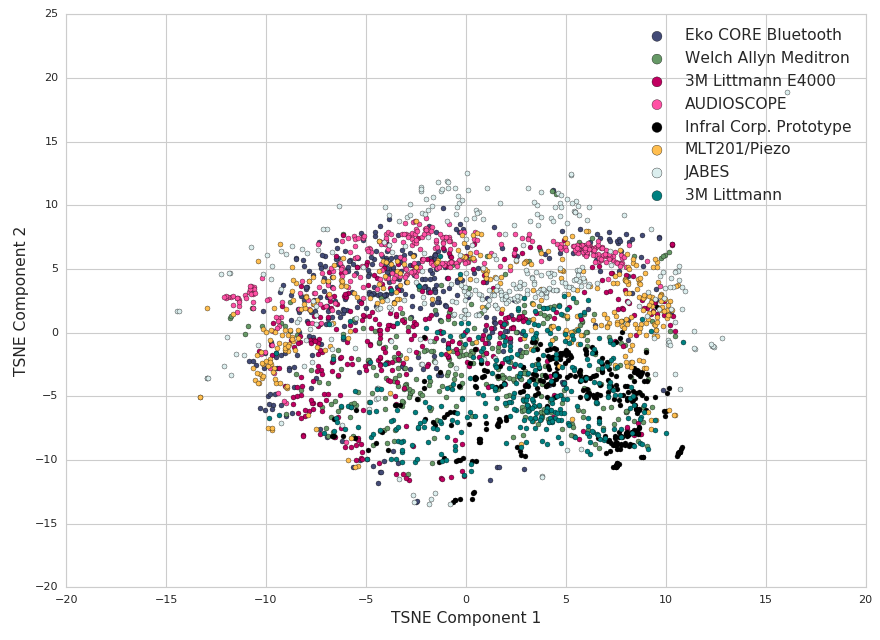

In [22]:
sns.set_style('whitegrid')
import matplotlib.font_manager as font_manager
font_prop = font_manager.FontProperties(size=14)
font_title = font_manager.FontProperties(size=20)

colors = ['#434B77',
          '#669966',
          '#c10061',
          '#ff51a5',
          'k',
          '#ffbe4f',
#           '#008080',
          '#DBEEEE',
          '#008080',
         ]
y_ = y.copy()
y_[y==11] = 14
y_[y>6] = y_[y>6] - 7 # 0-7 steth labels
y_ = y+1
y_[y_==7] = 0
y_[y_==8] = 7
# y_ = y_>6
subsets = ["Eko CORE Bluetooth",
"Welch Allyn Meditron",
"3M Littmann E4000",
"AUDIOSCOPE",
"Infral Corp. Prototype",
"MLT201/Piezo",
"JABES",
"3M Littmann"]
parser = dict(zip(np.unique(y_),subsets))
fig = plt.figure(figsize=(11,8))
for stage,color in zip(np.unique(y_),colors):
    mask = y_ == stage
    plt.scatter(X_embedded[mask,0],X_embedded[mask,1],c=color,label=parser[stage])
plt.legend(markerscale=2,fontsize=14)
fig.set_tight_layout(tight=1)
plt.xlabel('TSNE Component 1',fontproperties=font_prop)
plt.ylabel('TSNE Component 2',fontproperties=font_prop)
plt.show()

# plt.savefig('potesTSNE.eps')

In [ ]:
fig = plt.figure(figsize=(7,5))
conf = model_confidence(model,x_val,y_val)
conf = cc2parts(conf,val_parts)
plt.hist(conf)
plt.show()